In [5]:
import sys
sys.path.insert(1, '../GBT_pipeline')
from synthetic_real import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
import matplotlib.pyplot as plt
import numpy as np 
from single_search import search
from execute_model import model_load
import tensorflow as tf
from numba import njit, jit, prange
from sklearn.metrics import silhouette_score

@njit(nopython=True)
def pre_proc(data):
#   data= data - data.min()+1
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data
@jit(parallel=True)
def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [6]:
NUM_SAMPLES = 10
factor =1

print("Loading in plate")
plate = np.load('../../real_filtered.npy')
print("Creating False")

false_data = create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES, snr_base=300, snr_range=10)
print("Creating True")

true_data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES, snr_base=10, snr_range=10, factor=factor)
print("Creating Single Shot True")

true_single_shot = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES, snr_base=10, snr_range=10,factor=factor)


Loading in plate
Creating False
Creating True
Creating Single Shot True


In [7]:
print(false_data.min())

-4408618457608.567


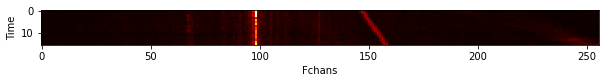

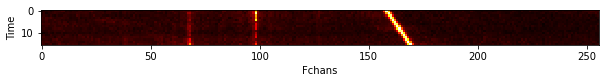

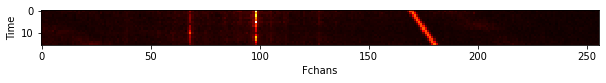

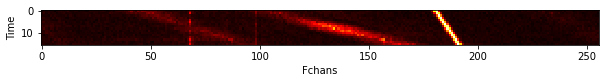

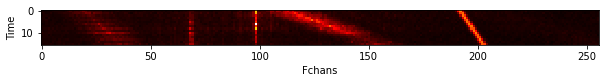

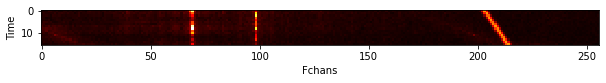

In [8]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(false_data[4,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

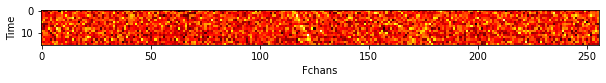

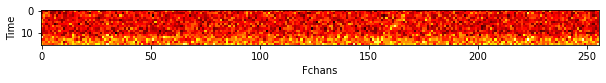

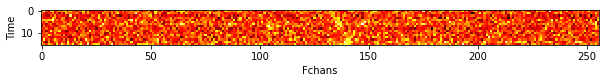

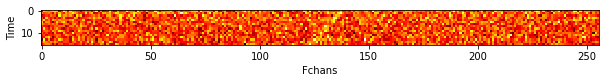

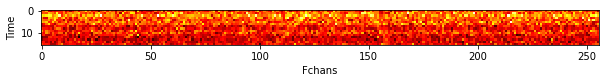

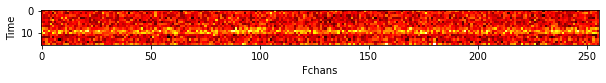

In [11]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[9,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

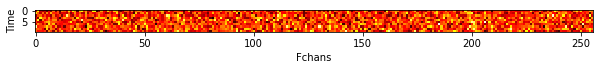

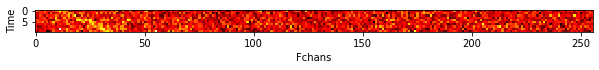

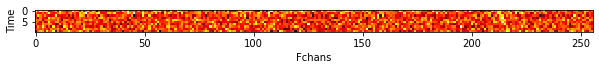

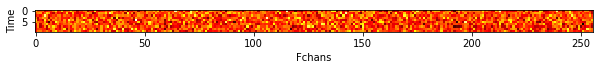

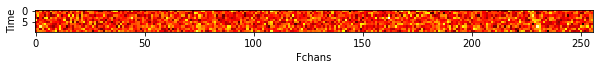

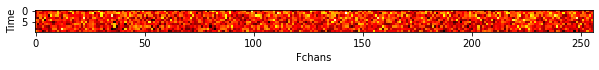

In [12]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_single_shot[1,,:10,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

In [ ]:
def strong_cadence_pattern(labels):
    return labels[0]!=labels[1] and labels[1]!=labels[2] and labels[2]!= labels[3] and labels[3]!=labels[4] and labels[4]!=labels[5] 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

%matplotlib inline
model = model_load("VAE-ENCODERv27.h5")
data = pre_proc(abs(false_data))
print(data.shape)
num_samples = data.shape[0]
cadence_length = data.shape[1]
data = data[..., np.newaxis]
print("Collapse Data")
data = combine(data)
print(data.shape)
# for i in range(6):
#     plt.figure(figsize=(10,4))
#     plt.xlabel("Fchans")
#     plt.ylabel("Time")
#     plt.imshow(data[i,:,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     plt.show()
# print("Push Through Neural Net")
result = model.predict(data)[2]

count = 0
for i in range(NUM_SAMPLES):
    cadence = result[i*6:(i+1)*6]
    clustering  = SpectralClustering(n_clusters=2, n_components = 2, assign_labels="discretize", random_state=0).fit_predict(cadence)
    clustering = [1, 1, 1, 1, 0, 1]
    fit = silhouette_score(cadence, clustering)
    if strong_cadence_pattern(clustering)==False:
        count+=1

print(count)
# 9627

In [ ]:
i=3
cadence = result[i*6:(i+1)*6]
print(cadence.shape)
print(np.linalg.norm((cadence[0]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm((cadence[0]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm((cadence[0]-cadence[5])))


print(np.linalg.norm((cadence[2]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm((cadence[2]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm((cadence[2]-cadence[5])))


print(np.linalg.norm((cadence[4]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm((cadence[4]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm((cadence[4]-cadence[5])))

print("-----")

print(np.linalg.norm(cadence[0]-cadence[2]))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(cadence[2]-cadence[4]))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(cadence[0]-cadence[4]))

print(np.linalg.norm(cadence[1]-cadence[3]))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(cadence[3]-cadence[5]))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(cadence[5]-cadence[1]))

In [ ]:
import tensorflow as tf

a = tf.convert_to_tensor(cadence[0,:], dtype=tf.float64)
b=  tf.convert_to_tensor(cadence[1,:], dtype=tf.float64)
tf.math.reduce_euclidean_norm(a-b, axis=0)

In [ ]:
model = model_load("VAE-ENCODERv34.h5")
data = pre_proc(abs(false_data))[...,np.newaxis]
print(data.shape)
a1 = tf.convert_to_tensor(model.predict(data[:,0,:,:,:])[2])
b =  tf.convert_to_tensor(model.predict(data[:,1,:,:,:])[2])
a2 =  tf.convert_to_tensor(model.predict(data[:,2,:,:,:])[2])
c =  tf.convert_to_tensor(model.predict(data[:,3,:,:,:])[2])
a3 =  tf.convert_to_tensor(model.predict(data[:,4,:,:,:])[2])
d =  tf.convert_to_tensor(model.predict(data[:,5,:,:,:])[2])


@tf.function
def loss_same(a,b):
    return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))
    
print(loss_same(a1,b))
print(loss_same(a1,c))
print(loss_same(a1,d))

print(loss_same(a2,b))
print(loss_same(a2,c))
print(loss_same(a2,d))

print(loss_same(a3,b))
print(loss_same(a3,c))
print(loss_same(a3,d))

print("----")
print(loss_same(a1,a2))
print(loss_same(a1,a3))
print(loss_same(a2,a3))

print(loss_same(b,c))
print(loss_same(c,d))
print(loss_same(b,d))

In [ ]:
import tensorflow as tf

a = tf.constant(cadence[0,:], dtype=tf.float64)
b=  tf.constant(cadence[3,:], dtype=tf.float64)
tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))